In [1]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image

# Define the CNN Model with 5 Convolutional Layers
class DogHeartNet(nn.Module):
    def __init__(self, num_classes=3):
        super(DogHeartNet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.1),  # Added dropout
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1),  # Added dropout
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),  # Adjust based on input size
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for FC layer
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Custom Dataset for Test Data
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.file_names = []

        # Collect all image paths
        for file in os.listdir(root_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(root_dir, file))
                self.file_names.append(file)

        print(f"Loaded {len(self.images)} test images from {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        file_name = self.file_names[idx]

        if self.transform:
            image = self.transform(image)

        return image, file_name

# Enhanced Data Augmentation
transform_train = transforms.Compose([
    #transforms.RandomHorizontalFlip(),  # Added horizontal flip
    transforms.RandomRotation(15),     # Slightly increased rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Added random crop
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset and DataLoader setup
dataset_dir = '/Users/sumitkumar/Downloads/Dog_heart'

train_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, "Train"), transform=transform_train)
validation_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, "Valid"), transform=transform_val)
test_dataset = TestDataset(root_dir=os.path.join(dataset_dir, "Test-2"), transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(validation_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

# Create an instance of the model
model = DogHeartNet(num_classes=3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Increased weight decay
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)  # Cosine annealing scheduler

# Training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Validation loop
def validate(model, validation_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    val_loss /= len(validation_loader.dataset)
    accuracy = correct / len(validation_loader.dataset)
    return val_loss, accuracy

# Test and generate predictions
def test_and_predict(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data, file_names in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).cpu().numpy()
            for fname, p in zip(file_names, pred):
                predictions.append((fname, p.item()))
    return predictions

# Training process
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model.to(device)

num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, validation_loader, criterion, device)
    scheduler.step()  # Step the scheduler
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions for test dataset
predictions = test_and_predict(model, test_loader, device)

# Save predictions to CSV
output_file = 'dog_heart_predictions.csv'
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(predictions)

print(f"Predictions saved to {output_file}")


Loaded 400 test images from /Users/sumitkumar/Downloads/Dog_heart/Test-2
Number of training samples: 1400
Number of validation samples: 200
Number of test samples: 400
Classes: ['Large', 'Normal', 'Small']
Epoch 1/30, Train Loss: 5.1651, Validation Loss: 0.0419, Validation Accuracy: 0.4400
Epoch 2/30, Train Loss: 1.3312, Validation Loss: 0.0378, Validation Accuracy: 0.5150
Epoch 3/30, Train Loss: 1.0153, Validation Loss: 0.0368, Validation Accuracy: 0.4800
Epoch 4/30, Train Loss: 0.9553, Validation Loss: 0.0340, Validation Accuracy: 0.4750
Epoch 5/30, Train Loss: 0.9399, Validation Loss: 0.0336, Validation Accuracy: 0.5100
Epoch 6/30, Train Loss: 0.9348, Validation Loss: 0.0355, Validation Accuracy: 0.4750
Epoch 7/30, Train Loss: 0.9213, Validation Loss: 0.0320, Validation Accuracy: 0.5250
Epoch 8/30, Train Loss: 0.9211, Validation Loss: 0.0318, Validation Accuracy: 0.5400
Epoch 9/30, Train Loss: 0.8972, Validation Loss: 0.0338, Validation Accuracy: 0.5600
Epoch 10/30, Train Loss: 0.88

In [2]:
model_path = "/Users/sumitkumar/Downloads/model.pt"

# Save the model
torch.save(model.state_dict(), model_path)

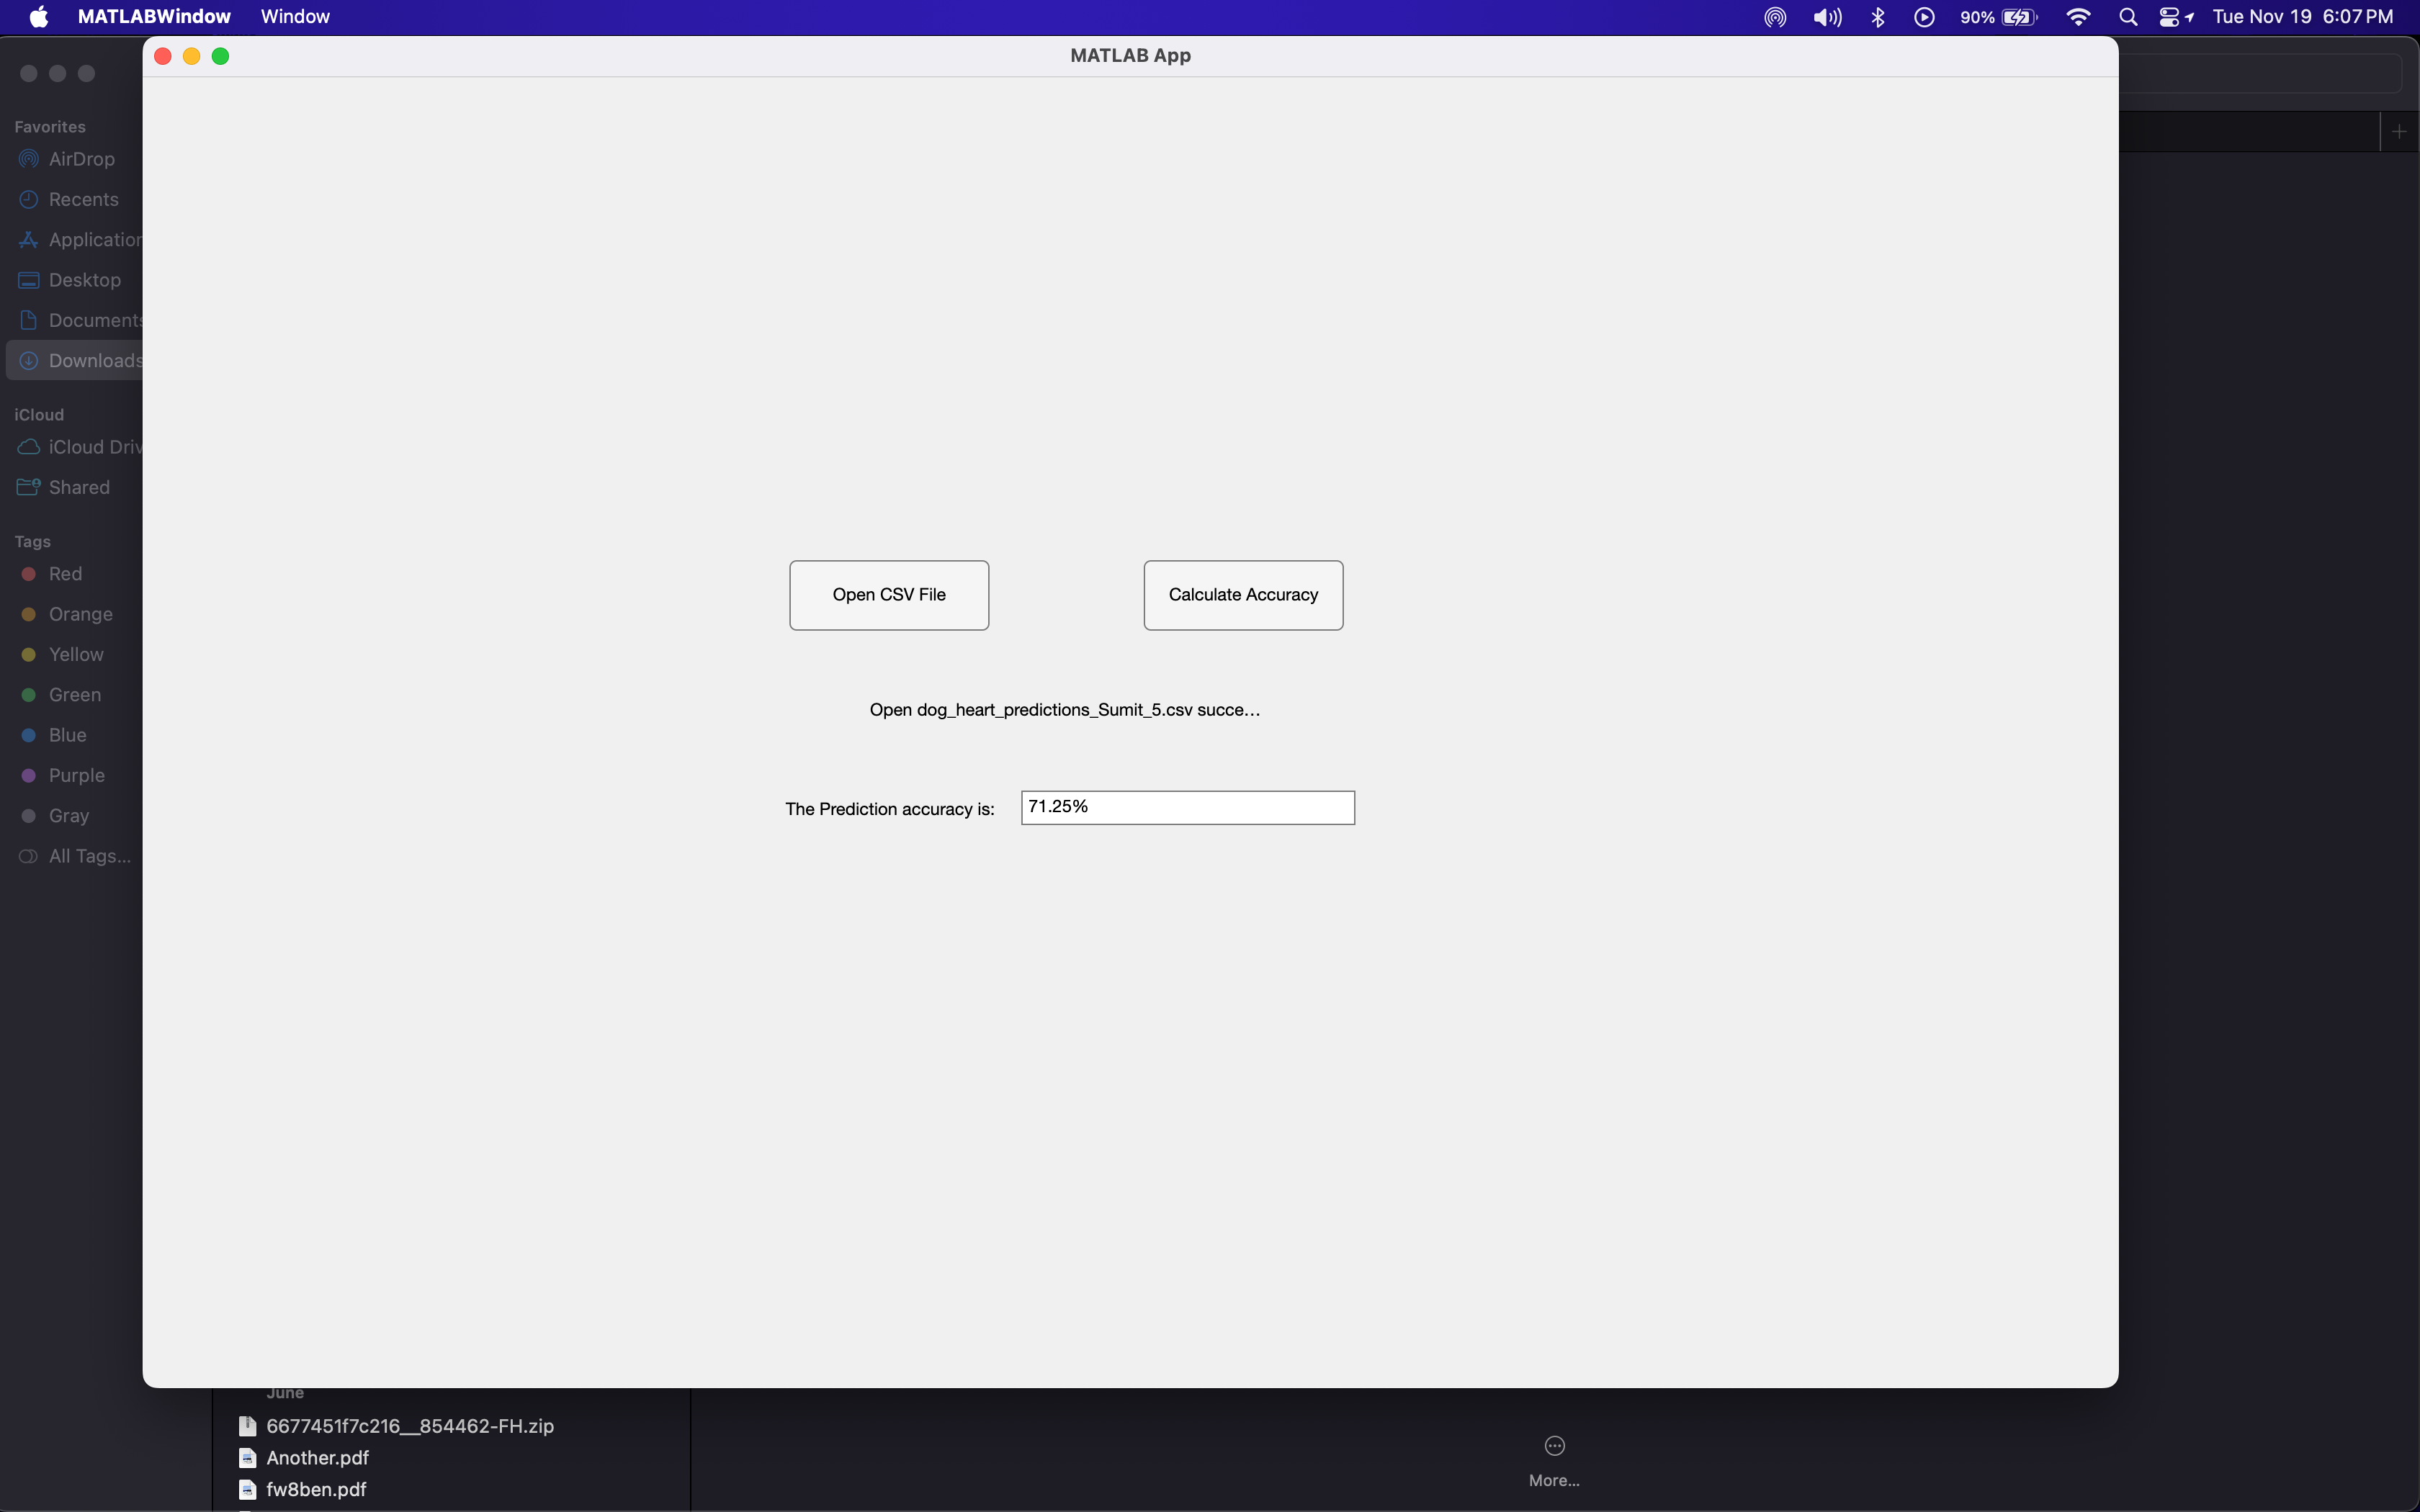